# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [84]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.exceptions import ConvergenceWarning
import warnings
import time

## Supervised learning - classification
Now we load the initial dataset.

In [3]:
# Load the dataset
df = pd.read_csv("ddos_dataset.csv", header=0, index_col=0, engine='python')

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

df


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


We decided to use the following algorithms to perform supervised learning:
- K-NN
- multi-class Logistic Regression (one-vs-rest scheme)
- Random Forest
- SVM
- Gaussian Naive Bayes

Then, we proceed analyzing their performances using the default parameters.

First of all, we perform some basic preprocessing (handling categorical and inconsistent features).

In [4]:
# Remove inconsistent features
columns_to_delete = ['Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'min_seg_size_forward', 'Fwd Avg Bytes/Bulk',  'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',  'Bwd Avg Packets/Bulk',  'Bwd Avg Bulk Rate', 'PSH Flag Count', 'FIN Flag Count', 'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags']
print(f"Removed features: {columns_to_delete}")
df_cleaned = df.drop(columns_to_delete, axis=1)

Removed features: ['Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Header Length.1', 'min_seg_size_forward', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'PSH Flag Count', 'FIN Flag Count', 'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags']


In [5]:
# Remove/transform categorical features
def to_binary(ip):
    parts = ip.split('.')
    return (int(parts[0]) << 24) + (int(parts[1]) << 16) + (int(parts[2]) << 8) + int(parts[3])

df_cleaned['Source IP'] = df_cleaned['Source IP'].apply(to_binary)
df_cleaned['Destination IP'] = df_cleaned['Destination IP'].apply(to_binary)
df_cleaned = df_cleaned.drop(['Flow ID', 'SimillarHTTP', 'Timestamp'], axis=1)
idx_protocol = df_cleaned.columns.get_loc('Protocol')

In [ ]:
# Label encoding
le = LabelEncoder()
df_cleaned['label'] = le.fit_transform(df['label'])

Then we need to split the dataset into train and test set.

In [7]:
X_df = df_cleaned.drop(columns='label')
y_df = df_cleaned[['label']]

# run stratified training-test splitting using train_test_split
X_train_val_in, X_test_in, y_train_val, y_test = train_test_split(X_df, y_df, stratify=y_df, train_size=0.7, random_state=15)
y_train_val, y_test = np.ravel(y_train_val.to_numpy()), np.ravel(y_test.to_numpy())

Now we follow the same steps already described in file 2. In this case, we need to fit the StandardScaler only on the train set not to influence the test set. We also compute the highly correlated features on the train set, then we drop them both on the train and test set.

In [8]:
# Perform one-hot encoding on the protocol feature
enc = OneHotEncoder(handle_unknown='ignore')
to_encode_protocol_train = np.reshape(X_train_val_in.iloc[:, idx_protocol], (-1, 1))
to_encode_protocol_test = np.reshape(X_test_in.iloc[:, idx_protocol], (-1, 1))
enc.fit(to_encode_protocol_train)

features_enc_train = enc.transform(to_encode_protocol_train).toarray()
features_enc_test = enc.transform(to_encode_protocol_test).toarray()
columns = ["Protocol_0","Protocol_6","Protocol_17"]
features_enc_train_df = pd.DataFrame(features_enc_train, columns=columns,index=X_train_val_in.index)
features_enc_test_df = pd.DataFrame(features_enc_test, columns=columns,index=X_test_in.index)

X_train_val_protocol = X_train_val_in.drop('Protocol', axis=1)
X_test_protocol = X_test_in.drop('Protocol', axis=1)
X_train_val_protocol = pd.concat([X_train_val_protocol, features_enc_train_df], axis=1)
X_test_protocol = pd.concat([X_test_protocol, features_enc_test_df], axis=1)

In [9]:
scaler = StandardScaler()
columns = X_train_val_protocol.columns

X_train_val_scaled = X_train_val_protocol.copy()
X_test_scaled = X_test_protocol.copy()

for col in columns:

    # fit the scaler on the data
    scaler.fit(X_train_val_protocol[col].values.reshape(-1, 1))

    # transform the data
    X_train_val_scaled[col] = scaler.transform(X_train_val_protocol[col].values.reshape(-1, 1))
    X_test_scaled[col] = scaler.transform(X_test_protocol[col].values.reshape(-1, 1))

In [123]:
correlation_matrix = X_train_val_scaled.corr().abs()
c = correlation_matrix[correlation_matrix > 0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlated features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]
to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print("Cleaned dataset")
print(len(to_be_deleted), 'features are removed:', sorted(to_be_deleted))
print(len(X_train_val_scaled.columns) - len(to_be_deleted), 'features are kept.')

X_train_val_df = X_train_val_scaled.drop(to_be_deleted, axis=1)
X_test_df = X_test_scaled.drop(to_be_deleted, axis=1)

X_train_val = X_train_val_df.to_numpy()
X_test = X_test_df.to_numpy()

Cleaned dataset
37 features are removed: ['Active Max', 'Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Destination IP', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd PSH Flags', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Min', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Protocol_17', 'Protocol_6', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets', 'URG Flag Count']
28 features are kept.


Here we train the models using the default parameters. Then we print the classification report, and plot the confusion matrix.

In [ ]:
# k-NN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_val, y_train_val)
y_train_pred_knn = knn_clf.predict(X_train_val)
y_test_pred_knn = knn_clf.predict(X_test)

# LR
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train_val, y_train_val)
y_train_pred_lr = lr_clf.predict(X_train_val)
y_test_pred_lr = lr_clf.predict(X_test)

# RF
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_val, y_train_val)
y_train_pred_rf = rf_clf.predict(X_train_val)
y_test_pred_rf = rf_clf.predict(X_test)

# SVM
svc_clf = LinearSVC()
svc_clf.fit(X_train_val, y_train_val)
y_train_pred_svc = svc_clf.predict(X_train_val)
y_test_pred_svc = svc_clf.predict(X_test)

# GaussianNB
gaussianNB_clf = GaussianNB()
gaussianNB_clf.fit(X_train_val, y_train_val)
y_train_pred_gaussianNB = gaussianNB_clf.predict(X_train_val)
y_test_pred_gaussianNB = gaussianNB_clf.predict(X_test)


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# k-NN
print("k-NN")
# classification report
print('Training set')
print(classification_report(le.inverse_transform(y_train_val), le.inverse_transform(y_train_pred_knn)))
print('Test set')
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_knn)))

k-NN
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       0.98      0.90      0.94      3758
   ddos_ldap       0.65      0.86      0.74      4149
  ddos_mssql       0.74      0.55      0.63      4138
ddos_netbios       0.95      0.98      0.97      4081
    ddos_ntp       0.90      0.97      0.93       690
   ddos_snmp       0.99      1.00      1.00      4189
   ddos_ssdp       0.81      0.79      0.80      4179
    ddos_syn       0.99      0.98      0.98      3836
   ddos_tftp       0.98      0.99      0.98      3683
    ddos_udp       0.71      0.70      0.71      4113
ddos_udp_lag       0.72      0.70      0.71      4190

    accuracy                           0.86     44967
   macro avg       0.87      0.87      0.87     44967
weighted avg       0.86      0.86      0.86     44967

Test set
              precision    recall  f1-score   support

      benign       0.99      1.00      0.99      16

In [13]:
# LR
print("LOGISTIC REGRESSION")
# classification report
print('Training set')
print(classification_report(le.inverse_transform(y_train_val), le.inverse_transform(y_train_pred_lr), zero_division=0))
print('Test set')
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_lr), zero_division=0))

LOGISTIC REGRESSION
Training set
              precision    recall  f1-score   support

      benign       0.94      0.93      0.94      3961
    ddos_dns       0.97      0.83      0.89      3758
   ddos_ldap       0.50      0.64      0.56      4149
  ddos_mssql       0.22      0.03      0.05      4138
ddos_netbios       0.87      0.93      0.90      4081
    ddos_ntp       0.67      0.64      0.66       690
   ddos_snmp       0.96      1.00      0.98      4189
   ddos_ssdp       0.54      0.90      0.68      4179
    ddos_syn       0.96      0.98      0.97      3836
   ddos_tftp       0.97      0.96      0.96      3683
    ddos_udp       0.50      0.52      0.51      4113
ddos_udp_lag       0.53      0.49      0.51      4190

    accuracy                           0.74     44967
   macro avg       0.72      0.74      0.72     44967
weighted avg       0.72      0.74      0.71     44967

Test set
              precision    recall  f1-score   support

      benign       0.93      0.93   

In [14]:
# RF
print("RANDOM FOREST")
# classification report
print('Training set')
print(classification_report(le.inverse_transform(y_train_val), le.inverse_transform(y_train_pred_rf)))
print('Test set')
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_rf)))

RANDOM FOREST
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      1.00      1.00      3758
   ddos_ldap       1.00      1.00      1.00      4149
  ddos_mssql       1.00      1.00      1.00      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       1.00      1.00      1.00       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       1.00      1.00      1.00      4179
    ddos_syn       1.00      1.00      1.00      3836
   ddos_tftp       1.00      1.00      1.00      3683
    ddos_udp       1.00      1.00      1.00      4113
ddos_udp_lag       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967

Test set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.0

In [15]:
# SVM
print("SUPPORT VECTOR MACHINES (SVM)")
# classification report
print('Training set')
print(classification_report(le.inverse_transform(y_train_val), le.inverse_transform(y_train_pred_svc), zero_division=0))
print('Test set')
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_svc), zero_division=0))

SUPPORT VECTOR MACHINES (SVM)
Training set
              precision    recall  f1-score   support

      benign       0.93      0.93      0.93      3961
    ddos_dns       1.00      0.80      0.89      3758
   ddos_ldap       0.49      0.66      0.56      4149
  ddos_mssql       0.13      0.02      0.03      4138
ddos_netbios       0.51      0.97      0.67      4081
    ddos_ntp       0.66      0.60      0.63       690
   ddos_snmp       0.95      1.00      0.97      4189
   ddos_ssdp       0.54      0.87      0.66      4179
    ddos_syn       0.96      0.98      0.97      3836
   ddos_tftp       0.97      0.95      0.96      3683
    ddos_udp       0.51      0.36      0.42      4113
ddos_udp_lag       0.49      0.23      0.31      4190

    accuracy                           0.70     44967
   macro avg       0.68      0.70      0.67     44967
weighted avg       0.67      0.70      0.66     44967

Test set
              precision    recall  f1-score   support

      benign       0.93   

In [16]:
# Naive Bayes Classifier
print("NAIVE BAYES CLASSIFIER")
# classification report
print('Training set')
print(classification_report(le.inverse_transform(y_train_val),le.inverse_transform( y_train_pred_gaussianNB), zero_division=0))
print('Test set')
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred_gaussianNB), zero_division=0))

NAIVE BAYES CLASSIFIER
Training set
              precision    recall  f1-score   support

      benign       0.99      0.67      0.80      3961
    ddos_dns       0.97      0.81      0.88      3758
   ddos_ldap       0.71      0.02      0.03      4149
  ddos_mssql       0.80      0.00      0.00      4138
ddos_netbios       0.86      0.51      0.64      4081
    ddos_ntp       0.34      0.98      0.50       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       0.33      1.00      0.50      4179
    ddos_syn       0.52      1.00      0.69      3836
   ddos_tftp       0.99      0.04      0.09      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.43      1.00      0.60      4190

    accuracy                           0.56     44967
   macro avg       0.66      0.59      0.48     44967
weighted avg       0.68      0.56      0.47     44967

Test set
              precision    recall  f1-score   support

      benign       0.99      0.65

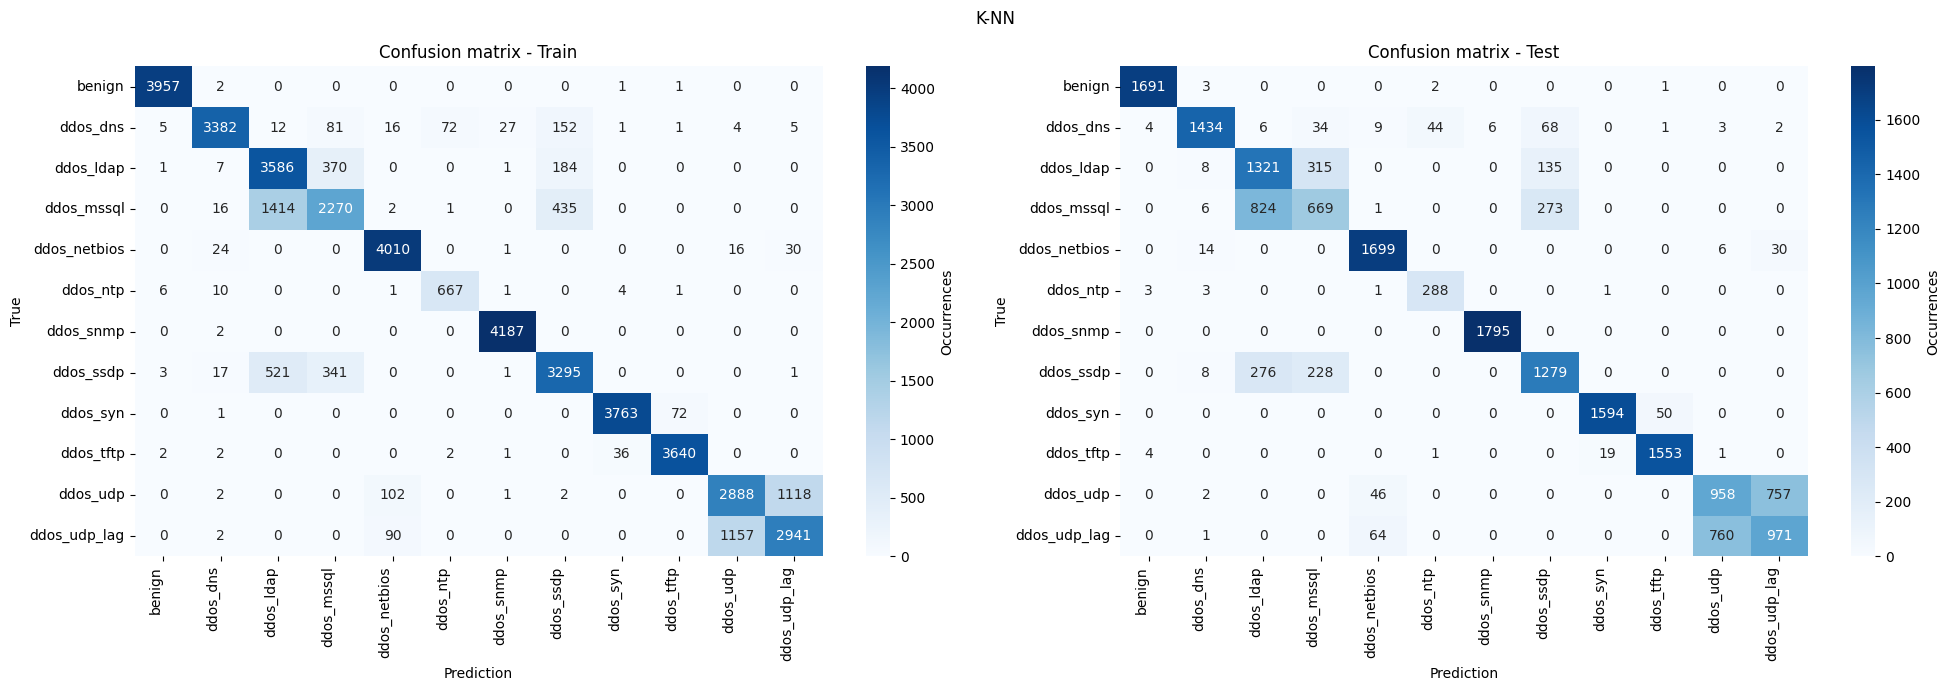

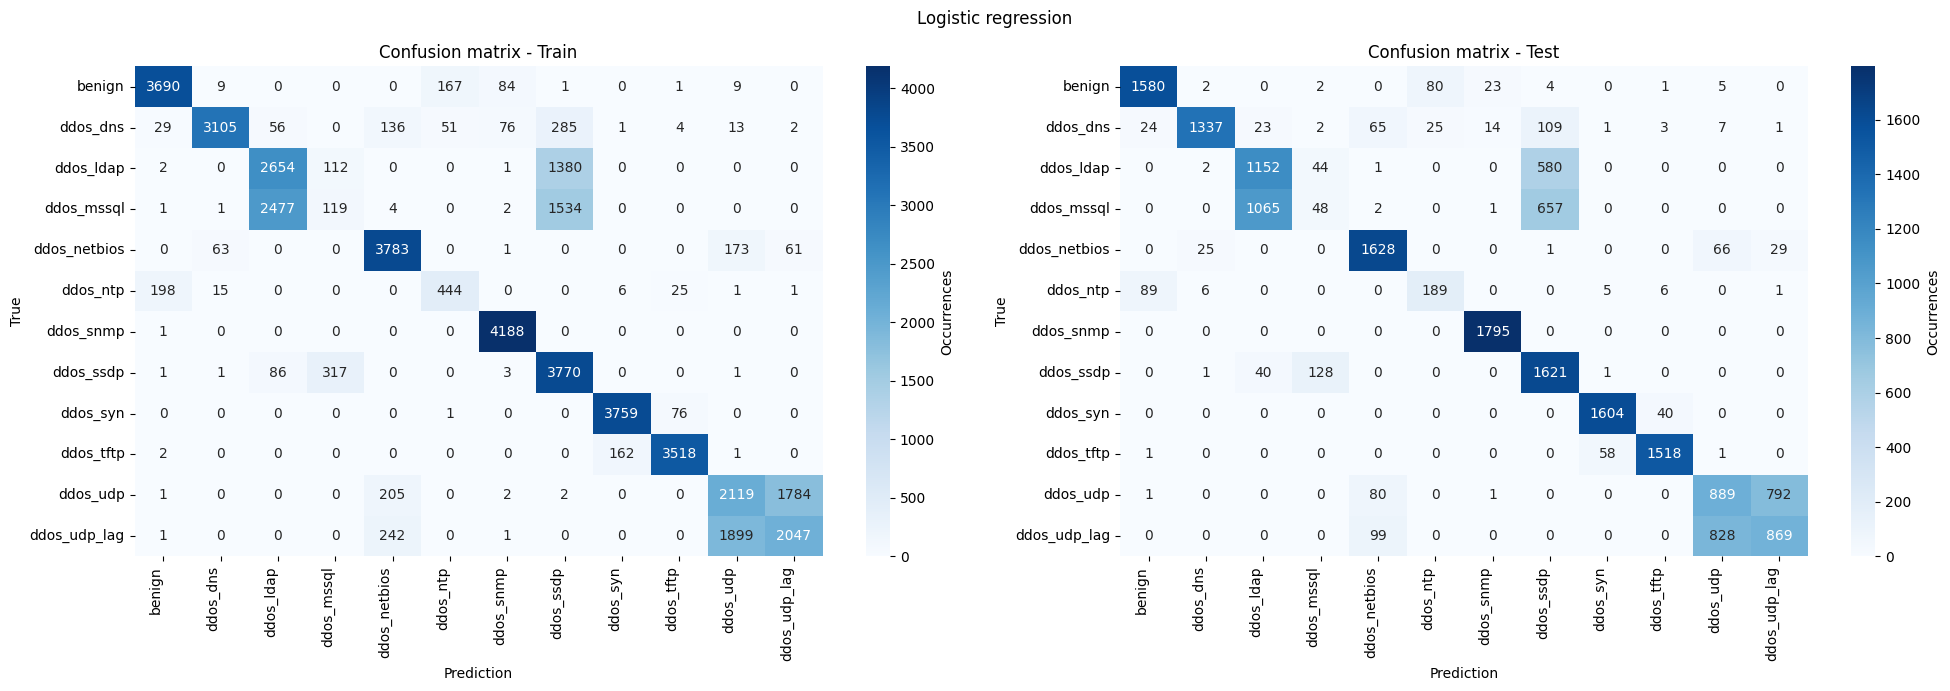

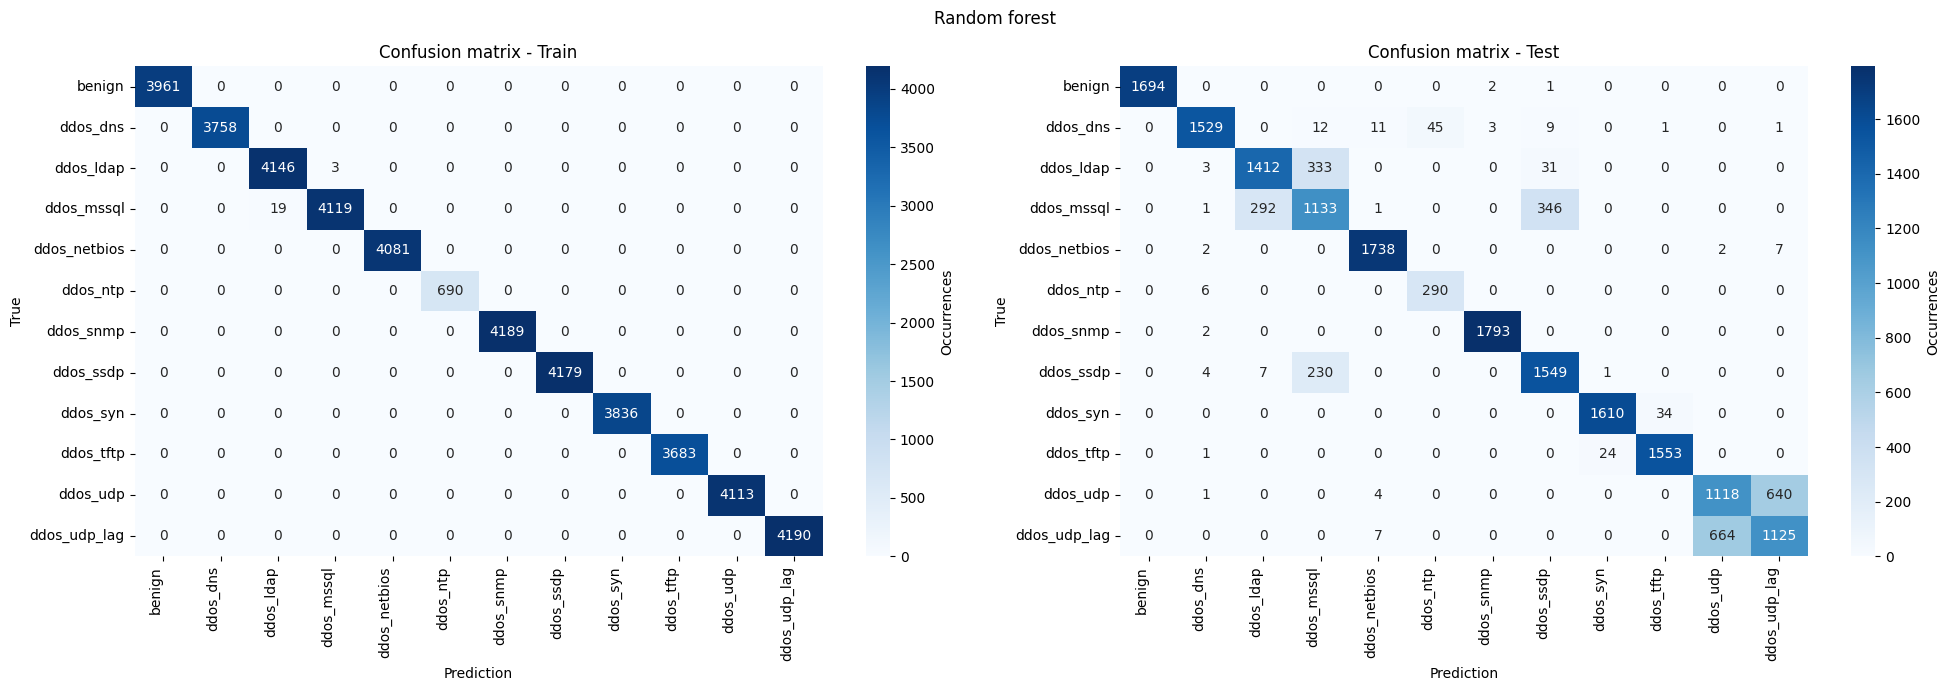

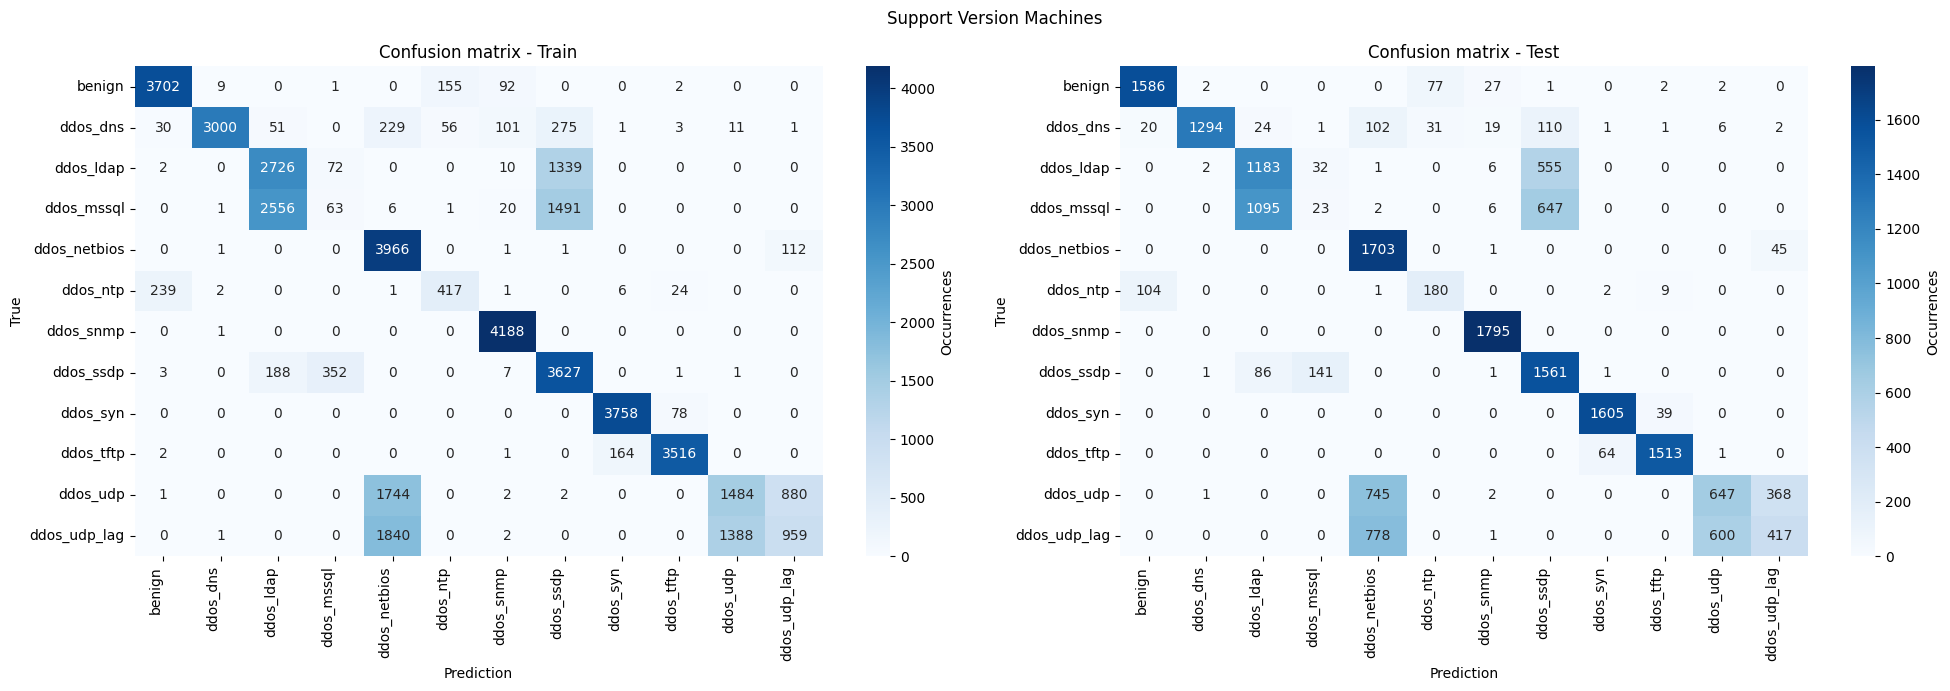

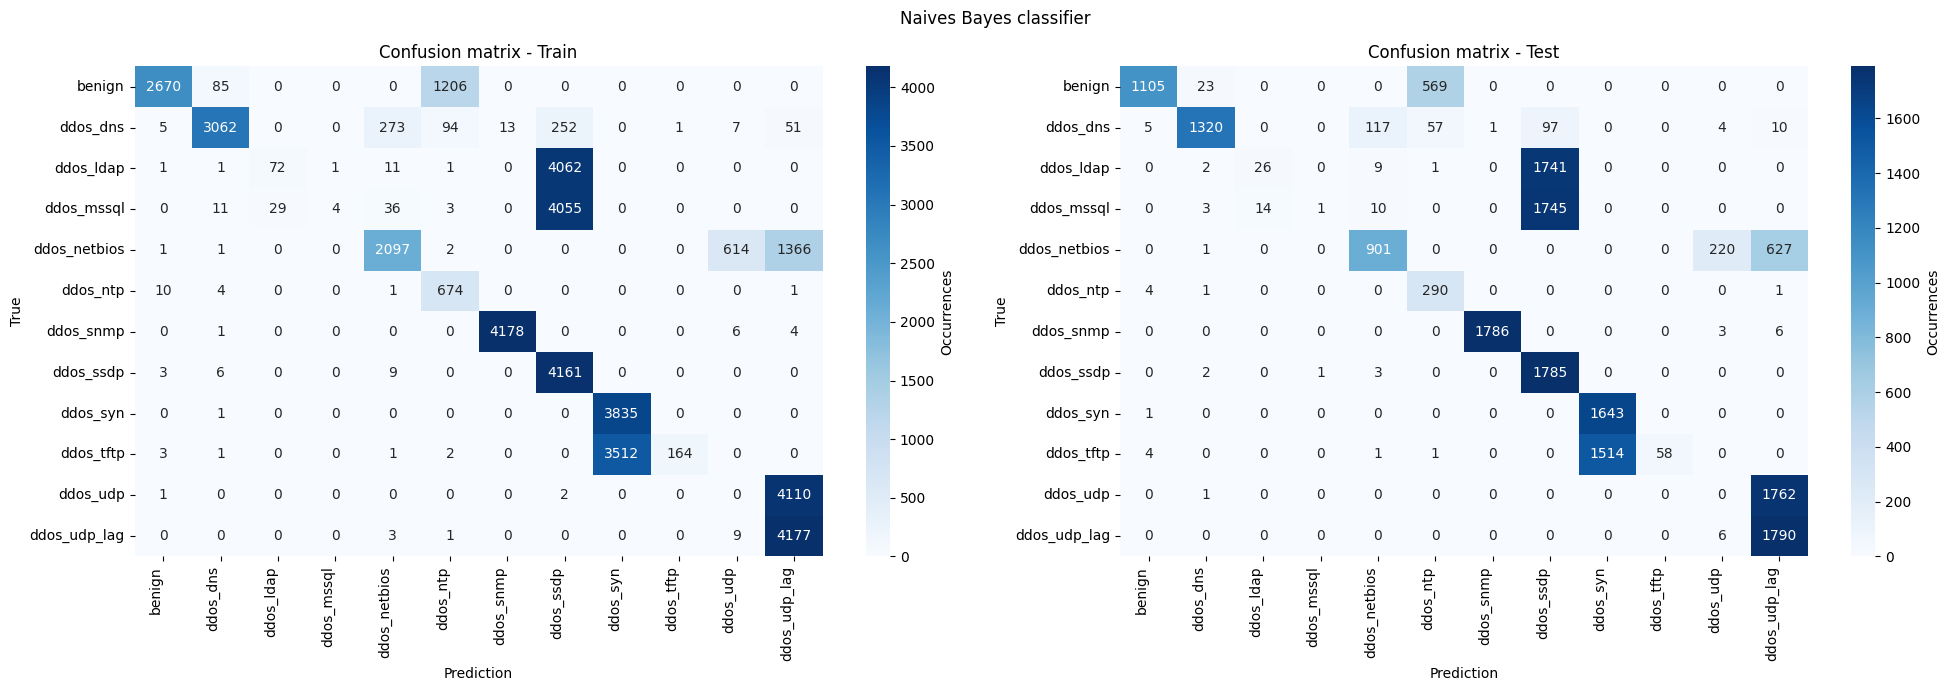

In [17]:
titles = [
    "K-NN",
    "Logistic regression",
    "Random forest",
    "Support Version Machines",
    "Naives Bayes classifier"
]

y_train_preds = [
    y_train_pred_knn,
    y_train_pred_lr,
    y_train_pred_rf,
    y_train_pred_svc,
    y_train_pred_gaussianNB,
]

y_test_preds = [
    y_test_pred_knn,
    y_test_pred_lr,
    y_test_pred_rf,
    y_test_pred_svc,
    y_test_pred_gaussianNB,
]

for title, y_train_pred, y_test_pred in zip(titles, y_train_preds, y_test_preds):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title)

    confusion_train = confusion_matrix(y_train_val, y_train_pred)
    sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
    ax1.set_xlabel('Prediction')
    ax1.set_ylabel('True')
    ax1.set_title('Confusion matrix - Train')

    confusion_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
    ax2.set_xlabel('Prediction')
    ax2.set_ylabel('True')
    ax2.set_title('Confusion matrix - Test')

    labels = le.inverse_transform(range(12))
    ax1.xaxis.set_ticklabels(labels, rotation=90, ha='right')
    ax1.yaxis.set_ticklabels(labels, rotation=0, ha='right')
    ax2.xaxis.set_ticklabels(labels, rotation=90, ha='right')
    ax2.yaxis.set_ticklabels(labels, rotation=0, ha='right')

    plt.tight_layout()
    plt.show()

We noticed that:
- K-NN confuses classes ddos_ldap, ddos_mssql and ddos_ssdp - ddos_udp and ddos_udp_lag; 
- LR misclassifies the samples of the class ddos_mssql (since it tends to classify it as ddos_ldap), confuses classes ddos_ldap, ddos_mssql and ddos_ssdp (and dns) - ddos_udp and ddos_udp_lag
- RF confuses classes ddos_ldap and ddos_mssql (similar to k-NN), tends to classify as ddos_ssdp ddos_mssql samples (but not vice versa ), ddos_udp and ddos_udp_lag (but it tends to misclassify ddos_udp as ddos_udp_lag less then the other models); 
- SVM misclassifications are similar to LR ones, but it as a lower accuracy.
- Naive Bayes tends to classify all ddos_udp samples as ddos_udp_lag, ddos_tftp as ddos_sy, ddos_ldap and ddos_mssql as ddos_ssdp.

It clearly stands out that Random Forest and k-NN models are the best in this initial analysis. They do not classify any malign traffic sample as benign.

## Hyper-parameter tuning
Now we perform hyper-parameter tuning for the models we have decided to use. We applied the GridSearchCV since it performs the stratified 5-fold cross-validation exploiting all the cores of the PC. Hence, the computation is definitely faster than a custom implementation.

In [ ]:
# Function to automatize the plot of the cross-validation graph
def plot_grid_search_graph(grid_search, x=None, x_label='configuration index', log_scale=False):
    plt.figure(figsize=(10,5))
    test_acc = grid_search.cv_results_['mean_test_score']
    train_acc = grid_search.cv_results_['mean_train_score']
    err_test_acc = grid_search.cv_results_['std_test_score']
    err_train_acc = grid_search.cv_results_['std_train_score']

    if x is None:
        x = list(range(1, len(test_acc)+1))

    plt.errorbar(x, train_acc,
                yerr=(err_train_acc, err_train_acc),
                marker='o',
                color='tab:blue', label='train',linestyle='')
    plt.errorbar(x, test_acc,
                yerr=(err_test_acc, err_test_acc),
                marker='o',
                color='tab:red', label='val',linestyle='')

    plt.xlabel(x_label, fontsize=25)
    plt.ylabel('accuracy', fontsize=25)
    plt.legend(fontsize=18)
    plt.tick_params(labelsize=22)

    if log_scale:
        plt.xscale('log')

    best_idx = x[grid_search.best_index_]
    plt.scatter(best_idx, grid_search.best_score_, marker='*', color='black', s=300, zorder=100)
    plt.show()

### KNN - hyper-parameter tuning

In [ ]:
param_grid_knn = {
    'n_neighbors': [5, 6, 7, 8, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto']
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(), param_grid=param_grid_knn, scoring=make_scorer(accuracy_score),
    refit=True, cv=5, n_jobs=-1,
    return_train_score = True, verbose=4)

grid_search_knn.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=(train=1.000, test=0.804) total time=   8.1s
[CV 1/5] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=(train=1.000, test=0.795) total time=   8.1s
[CV 5/5] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=(train=0.863, test=0.796) total time=   8.1s
[CV 3/5] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=(train=0.865, test=0.798) total time=   8.4s
[CV 2/5] END algorithm=auto, n_neighbors=5, p=1, weights=distance;, score=(train=1.000, test=0.801) total time=   8.5s
[CV 2/5] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=(train=0.863, test=0.795) total time=   8.4s
[CV 1/5] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=(train=0.865, test=0.793) total time=   8.3s
[CV 4/5] END algorithm=auto, n_neighbors=5, p=1, weights=uniform;, score=(train=0.864, test=0.798) total time

Best values: {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best accuracy: 0.803


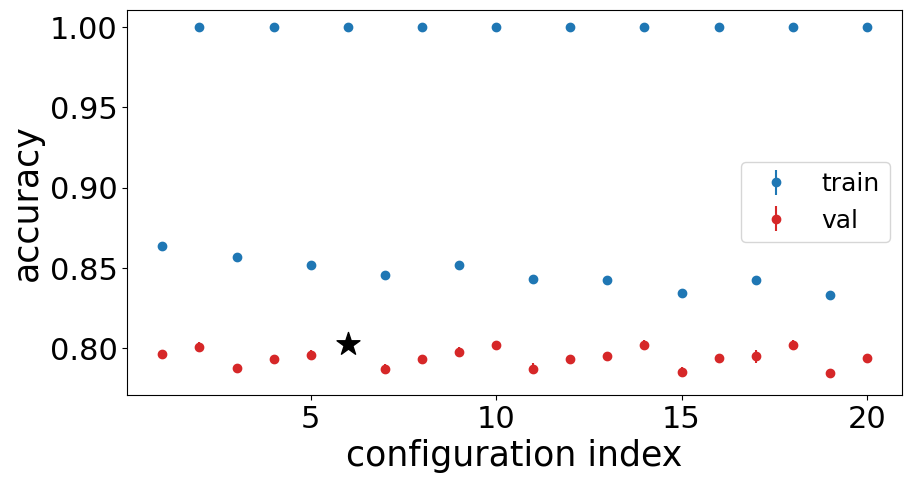

In [56]:
print('Best values:', grid_search_knn.best_params_)
print(f'Best accuracy: {grid_search_knn.best_score_:.3f}')
plot_grid_search_graph(grid_search_knn)

The selected combination is probably overfitting, but we can obtain a similar accuracy also with other combinations of hyper-parameters (without overfitting).

### Logistic Regression - hyper-parameter tuning

In [63]:
# Function to find the value of 'max_iter' that lead to convergence
def fit_until_convergence(X_train, y_train, max_iter_start, step, solver='lbfgs'):
    max_iter = max_iter_start
    count = 0
    while count < 10:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category=ConvergenceWarning)
                lr_clf = LogisticRegression(max_iter=max_iter, solver=solver, random_state=11)
                lr_clf.fit(X_train, y_train)
            print(f"Convergence reached with max_iter={max_iter}")
            return lr_clf   # return the trained model
        except ConvergenceWarning:
            print(f"Convergence NOT reached with max_iter={max_iter}, increasing iterations...")
            max_iter += step
            count += 1

# Now we try to observe if the model reaches convergence using the default solver ('lbfgs')

fit_until_convergence(X_train_val, y_train_val, max_iter_start=100, step=50, solver='lbfgs')

Convergence NOT reached with max_iter=100, increasing iterations...
Convergence NOT reached with max_iter=150, increasing iterations...
Convergence NOT reached with max_iter=200, increasing iterations...
Convergence NOT reached with max_iter=250, increasing iterations...
Convergence reached with max_iter=300


LogisticRegression(max_iter=300, random_state=11)

In [68]:
fit_until_convergence(X_train_val, y_train_val, max_iter_start=50, step=100, solver='newton-cg')

Convergence reached with max_iter=50


LogisticRegression(max_iter=50, random_state=11, solver='newton-cg')

Thanks to the code above we can notice that the Logistic Regression model converges after 300 iterations using the default solver, while with the 'newton-cg' solver it reaches the convergence almost immediately. With the 'saga' solver it didn't converge even after 1000 iterations.

In [73]:
param_grid_lr = [
    {'solver': ['lbfgs', 'newton-cg'], 'penalty': [None]},
    {'solver': ['lbfgs', 'newton-cg'], 'penalty': ['l2'], 'tol': [10**(-5), 10**(-4), 10**(-3)], 'C': [0.1, 1, 10]}
]

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=11), param_grid=param_grid_lr, scoring=make_scorer(accuracy_score),
    refit=True, cv=5, n_jobs=-1,
    return_train_score = True, verbose=4)

grid_search_lr.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END penalty=None, solver=lbfgs;, score=(train=0.745, test=0.746) total time=  13.6s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END penalty=None, solver=lbfgs;, score=(train=0.753, test=0.751) total time=  13.9s
[CV 5/5] END penalty=None, solver=lbfgs;, score=(train=0.750, test=0.748) total time=  13.9s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 1/5] END penalty=None, solver=lbfgs;, score=(train=0.749, test=0.745) total time=  14.2s
[CV 4/5] END penalty=None, solver=lbfgs;, score=(train=0.747, test=0.751) total time=  14.2s
[CV 1/5] END C=0.1, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.724, test=0.721) total time=   3.6s
[CV 3/5] END C=0.1, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.721, test=0.721) total time=   3.3s
[CV 2/5] END C=0.1, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.727, test=0.720) total time=   3.5s
[CV 1/5] END C=0.1, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.724, test=0.721) total time=   2.0s
[CV 5/5] END C=0.1, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.724, test=0.723) total time=   3.1s
[CV 4/5] END C=0.1, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.725, test=0.726) total time=   3.2s
[CV 2/5] END C=0.1, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.726, test=0.721) total time=   2.1s
[CV 3/5] END C=0.1, penalty=l2, solver=lbfgs, tol

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END C=10, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.745, test=0.742) total time=  14.0s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=10, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.750, test=0.746) total time=  14.1s
[CV 2/5] END C=10, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.749, test=0.745) total time=   7.5s
[CV 1/5] END C=10, penalty=l2, solver=lbfgs, tol=0.001;, score=(train=0.739, test=0.738) total time=   1.1s
[CV 2/5] END C=10, penalty=l2, solver=lbfgs, tol=0.001;, score=(train=0.745, test=0.741) total time=   1.2s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 3/5] END C=10, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.744, test=0.743) total time=  13.6s
[CV 4/5] END C=10, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.745, test=0.744) total time=  13.7s
[CV 3/5] END C=10, penalty=l2, solver=lbfgs, tol=0.001;, score=(train=0.740, test=0.739) total time=   1.1s
[CV 5/5] END C=10, penalty=l2, solver=lbfgs, tol=1e-05;, score=(train=0.746, test=0.743) total time=  13.7s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=10, penalty=l2, solver=lbfgs, tol=0.001;, score=(train=0.740, test=0.742) total time=   0.7s
[CV 3/5] END C=10, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.743, test=0.744) total time=   7.1s
[CV 5/5] END C=10, penalty=l2, solver=lbfgs, tol=0.001;, score=(train=0.739, test=0.736) total time=   1.1s
[CV 4/5] END C=10, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.745, test=0.745) total time=   7.6s
[CV 5/5] END C=10, penalty=l2, solver=lbfgs, tol=0.0001;, score=(train=0.747, test=0.744) total time=   8.2s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg, tol=1e-05;, score=(train=0.745, test=0.744) total time=  23.9s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg, tol=0.0001;, score=(train=0.749, test=0.746) total time=  28.2s
[CV 2/5] END C=10, penalty=l2, solver=newton-cg, tol=1e-05;, score=(train=0.749, test=0.745) total time=  31.4s
[CV 1/5] END C=10, penalty=l2, solver=newton-cg, tol=0.0001;, score=(train=0.745, test=0.742) total time=  30.9s
[CV 3/5

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=11),
             n_jobs=-1,
             param_grid=[{'penalty': [None], 'solver': ['lbfgs', 'newton-cg']},
                         {'C': [0.1, 1, 10], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg'],
                          'tol': [1e-05, 0.0001, 0.001]}],
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=4)

Best values: {'penalty': None, 'solver': 'newton-cg'}
Best accuracy: 0.748


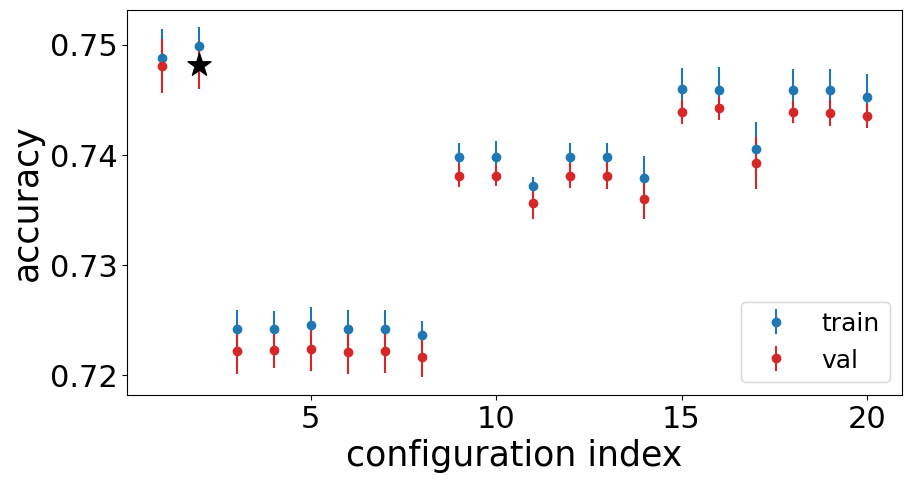

In [75]:
print('Best values:', grid_search_lr.best_params_)
print(f'Best accuracy: {grid_search_lr.best_score_:.3f}')
plot_grid_search_graph(grid_search_lr)

### Random Forest - hyper-parameter tuning

In [ ]:
param_grid_rf = {
    'n_estimators': range(50, 201, 25),
    'max_depth': [5, 10, 15, None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [1, 3, 5]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state = 11), param_grid=param_grid_rf, scoring=make_scorer(accuracy_score),
    refit=True, cv=5, n_jobs=-1,
    return_train_score = True, verbose=4)

grid_search_rf.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=50;, score=(train=0.806, test=0.804) total time=   1.3s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=50;, score=(train=0.806, test=0.801) total time=   1.3s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=50;, score=(train=0.811, test=0.806) total time=   1.3s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=50;, score=(train=0.807, test=0.813) total time=   1.4s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=50;, score=(train=0.806, test=0.805) total time=   1.4s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=75;, score=(train=0.812, test=0.810) total time=   2.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=1, n_estimators=75;, score=(train=0.813, test=0.809) total time=   2.0s
[CV 2/5] END criter

Best values: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 50}
Best accuracy: 0.873


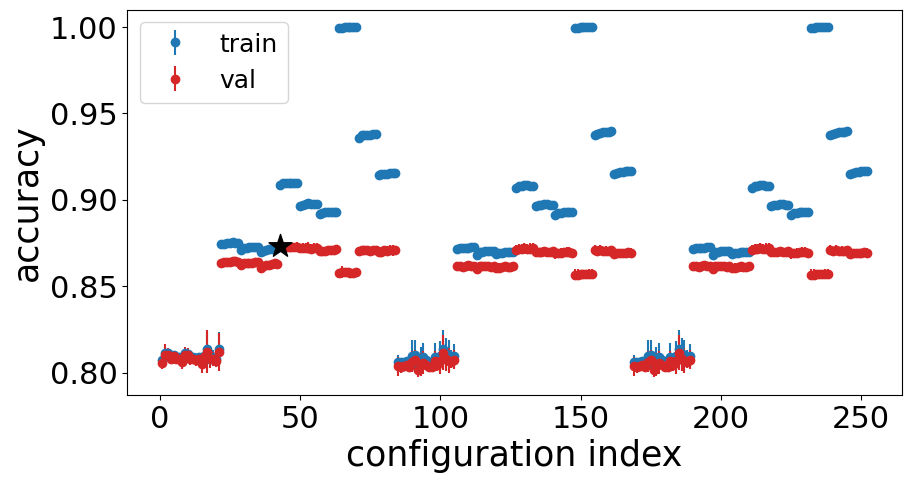

In [60]:
print('Best values:', grid_search_rf.best_params_)
print(f'Best accuracy: {grid_search_rf.best_score_:.3f}')
plot_grid_search_graph(grid_search_rf)

 We can notice that even using more trees (so increasing the cost) the performances more or less remain constant, so it is useless to use too many trees. This is the best model. 

### Support Vector Machines (SVM)
We use LinearSVC instead of SVC since it is more suitable for big datasets.

In [144]:
param_grid_svc = {
    'loss': ['squared_hinge'],
    'tol': [10**(-5), 10**(-4), 10**(-3)],
    'C': [0.1, 1, 10, 100]
}

grid_search_svc = GridSearchCV(
    estimator=LinearSVC(max_iter = 5000, random_state = 11), param_grid=param_grid_svc, scoring=make_scorer(accuracy_score),
    refit=True, cv=5, n_jobs=-1,
    return_train_score = True, verbose=4)

grid_search_svc.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.1, loss=squared_hinge, tol=0.0001;, score=(train=0.697, test=0.697) total time=  29.5s
[CV 3/5] END C=0.1, loss=squared_hinge, tol=0.0001;, score=(train=0.697, test=0.696) total time=  35.7s
[CV 3/5] END C=0.1, loss=squared_hinge, tol=1e-05;, score=(train=0.697, test=0.696) total time=  39.1s
[CV 1/5] END C=0.1, loss=squared_hinge, tol=1e-05;, score=(train=0.697, test=0.697) total time=  42.1s
[CV 2/5] END C=0.1, loss=squared_hinge, tol=0.0001;, score=(train=0.699, test=0.695) total time=  43.6s
[CV 4/5] END C=0.1, loss=squared_hinge, tol=1e-05;, score=(train=0.699, test=0.701) total time=  45.7s
[CV 2/5] END C=0.1, loss=squared_hinge, tol=1e-05;, score=(train=0.699, test=0.695) total time=  47.1s
[CV 5/5] END C=0.1, loss=squared_hinge, tol=1e-05;, score=(train=0.698, test=0.697) total time=  51.6s
[CV 1/5] END C=0.1, loss=squared_hinge, tol=0.001;, score=(train=0.697, test=0.697) total time=  13.2s
[CV 4/5] 

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=10, loss=squared_hinge, tol=0.0001;, score=(train=0.700, test=0.696) total time=19.8min
[CV 2/5] END C=10, loss=squared_hinge, tol=0.0001;, score=(train=0.701, test=0.696) total time=21.3min
[CV 1/5] END C=10, loss=squared_hinge, tol=0.0001;, score=(train=0.699, test=0.699) total time=22.6min
[CV 1/5] END C=10, loss=squared_hinge, tol=0.001;, score=(train=0.698, test=0.698) total time=  38.5s
[CV 2/5] END C=10, loss=squared_hinge, tol=0.001;, score=(train=0.701, test=0.696) total time=  41.2s
[CV 3/5] END C=10, loss=squared_hinge, tol=0.001;, score=(train=0.699, test=0.696) total time= 1.0min
[CV 4/5] END C=10, loss=squared_hinge, tol=0.001;, score=(train=0.699, test=0.704) total time=  31.0s
[CV 4/5] END C=10, loss=squared_hinge, tol=0.0001;, score=(train=0.699, test=0.704) total time= 5.5min
[CV 5/5] END C=10, loss=squared_hinge, tol=0.001;, score=(train=0.700, test=0.698) total time=  30.2s
[CV 5/5] END C=10, loss=squared_hinge, tol=0.0001;, score=(train=0.700, test=0

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=10, loss=squared_hinge, tol=1e-05;, score=(train=0.700, test=0.696) total time=30.9min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=10, loss=squared_hinge, tol=1e-05;, score=(train=0.700, test=0.698) total time=30.5min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=10, loss=squared_hinge, tol=1e-05;, score=(train=0.700, test=0.704) total time=31.4min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=10, loss=squared_hinge, tol=1e-05;, score=(train=0.701, test=0.697) total time=32.7min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=10, loss=squared_hinge, tol=1e-05;, score=(train=0.699, test=0.699) total time=32.9min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, loss=squared_hinge, tol=0.0001;, score=(train=0.701, test=0.702) total time=29.8min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, loss=squared_hinge, tol=0.0001;, score=(train=0.702, test=0.698) total time=30.6min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=100, loss=squared_hinge, tol=0.0001;, score=(train=0.702, test=0.698) total time=31.2min
[CV 1/5] END C=100, loss=squared_hinge, tol=0.001;, score=(train=0.699, test=0.699) total time=  46.4s
[CV 2/5] END C=100, loss=squared_hinge, tol=0.001;, score=(train=0.702, test=0.698) total time=  46.9s
[CV 3/5] END C=100, loss=squared_hinge, tol=0.001;, score=(train=0.700, test=0.697) total time= 1.4min
[CV 4/5] END C=100, loss=squared_hinge, tol=0.001;, score=(train=0.699, test=0.703) total time=  46.3s
[CV 5/5] END C=100, loss=squared_hinge, tol=0.001;, score=(train=0.701, test=0.700) total time=  39.8s


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END C=100, loss=squared_hinge, tol=1e-05;, score=(train=0.702, test=0.698) total time=41.4min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END C=100, loss=squared_hinge, tol=1e-05;, score=(train=0.702, test=0.698) total time=40.9min
[CV 5/5] END C=100, loss=squared_hinge, tol=0.0001;, score=(train=0.702, test=0.700) total time= 6.4min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END C=100, loss=squared_hinge, tol=1e-05;, score=(train=0.701, test=0.702) total time=41.9min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, loss=squared_hinge, tol=1e-05;, score=(train=0.701, test=0.705) total time=40.2min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END C=100, loss=squared_hinge, tol=0.0001;, score=(train=0.701, test=0.705) total time= 9.2min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END C=100, loss=squared_hinge, tol=1e-05;, score=(train=0.702, test=0.701) total time=39.7min


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=5000, random_state=11),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'loss': ['squared_hinge'],
                         'tol': [1e-05, 0.0001, 0.001]},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=4)

Best values: {'C': 100, 'loss': 'squared_hinge', 'tol': 1e-05}
Best accuracy: 0.701


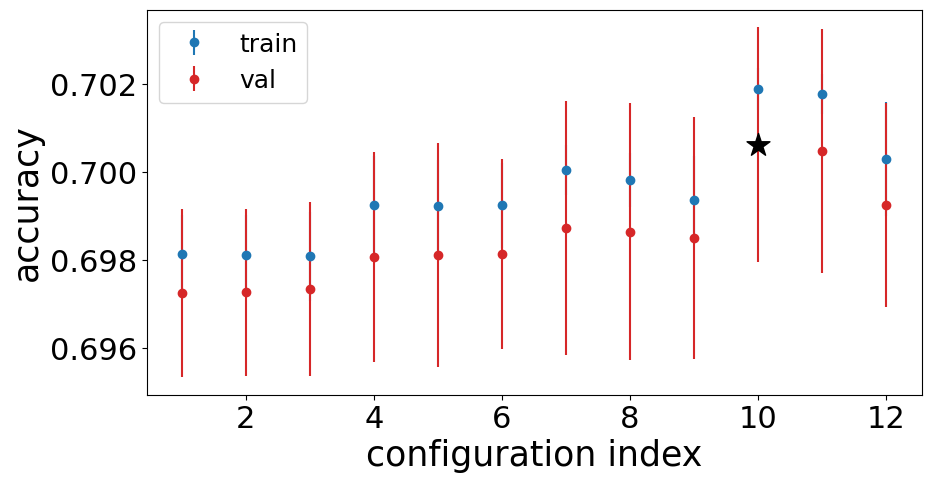

In [145]:
print('Best values:', grid_search_svc.best_params_)
print(f'Best accuracy: {grid_search_svc.best_score_:.3f}')
plot_grid_search_graph(grid_search_svc)

#### Naive Bayes Classifier

In [146]:
param_grid_nb = {
    'var_smoothing': [10**(-i) for i in range(20, -1, -1)],
}

grid_search_nb = GridSearchCV(
    estimator=GaussianNB(), param_grid=param_grid_nb, scoring=make_scorer(accuracy_score),
    refit=True, cv=5, n_jobs=-1,
    return_train_score = True, verbose=4)

grid_search_nb.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END var_smoothing=1e-20;, score=(train=0.533, test=0.536) total time=   0.0s
[CV 4/5] END var_smoothing=1e-19;, score=(train=0.500, test=0.495) total time=   0.0s
[CV 5/5] END var_smoothing=1e-19;, score=(train=0.454, test=0.454) total time=   0.0s
[CV 1/5] END var_smoothing=1e-18;, score=(train=0.535, test=0.540) total time=   0.1s
[CV 2/5] END var_smoothing=1e-18;, score=(train=0.548, test=0.547) total time=   0.1s
[CV 3/5] END var_smoothing=1e-20;, score=(train=0.514, test=0.513) total time=   0.1s
[CV 2/5] END var_smoothing=1e-20;, score=(train=0.546, test=0.545) total time=   0.1s
[CV 5/5] END var_smoothing=1e-20;, score=(train=0.454, test=0.454) total time=   0.1s
[CV 4/5] END var_smoothing=1e-20;, score=(train=0.462, test=0.457) total time=   0.1s
[CV 1/5] END var_smoothing=1e-19;, score=(train=0.533, test=0.537) total time=   0.1s
[CV 3/5] END var_smoothing=1e-18;, score=(train=0.515, test=0.514) total time=

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-20, 1e-19, 1e-18, 1e-17, 1e-16,
                                           1e-15, 1e-14, 1e-13, 1e-12, 1e-11,
                                           1e-10, 1e-09, 1e-08, 1e-07, 1e-06,
                                           1e-05, 0.0001, 0.001, 0.01, 0.1,
                                           1]},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=4)

Best values: {'var_smoothing': 0.1}
Best accuracy: 0.646


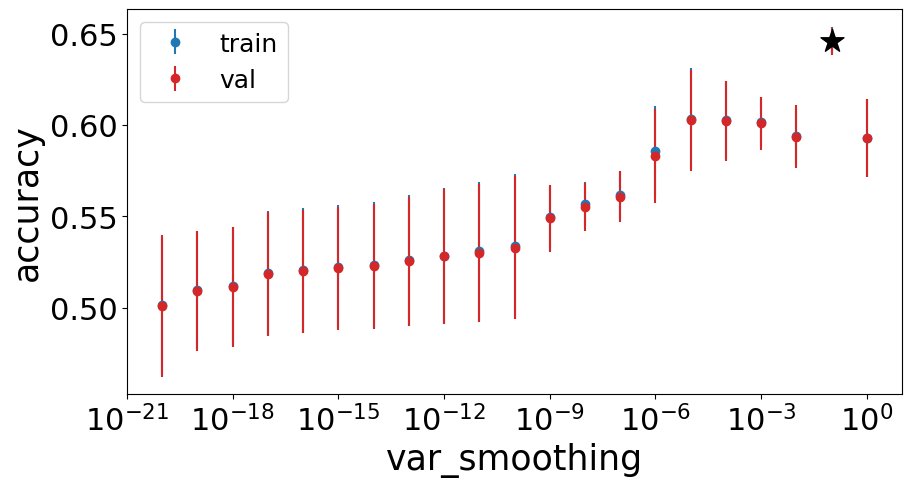

In [147]:
print('Best values:', grid_search_nb.best_params_)
print(f'Best accuracy: {grid_search_nb.best_score_:.3f}')
plot_grid_search_graph(grid_search_nb, param_grid_nb['var_smoothing'], x_label='var_smoothing', log_scale=True)

## Training and testing all the models with the best hyper-parameter values.
In this section we use the models already trained by GridSearchCV with the best combination of hyper-parameters in order to assess their performance.

In [148]:
# Print the classification reports
def print_classification_report(model, grid_search):
    clf = grid_search.best_estimator_
    predict_start = time.time()
    y_train_pred = clf.predict(X_train_val)
    y_test_pred = clf.predict(X_test)
    predict_end = time.time()
    print(f"{model} fit time: {grid_search.refit_time_:.2f}s - Predict time: {predict_end-predict_start:.2f}s")

    print()
    # classification report
    print('Training set')
    print(classification_report(le.inverse_transform(y_train_val), le.inverse_transform(y_train_pred), zero_division=0))
    print('Test set')
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_test_pred), zero_division=0))

#### k-NN

In [149]:
print_classification_report("k-NN", grid_search_knn)

k-NN fit time: 0.01s - Predict time: 11.25s

Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      1.00      1.00      3758
   ddos_ldap       1.00      1.00      1.00      4149
  ddos_mssql       1.00      1.00      1.00      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       1.00      1.00      1.00       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       1.00      1.00      1.00      4179
    ddos_syn       1.00      1.00      1.00      3836
   ddos_tftp       1.00      1.00      1.00      3683
    ddos_udp       1.00      1.00      1.00      4113
ddos_udp_lag       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967

Test set
              precision    recall  f1-score   support

      benig

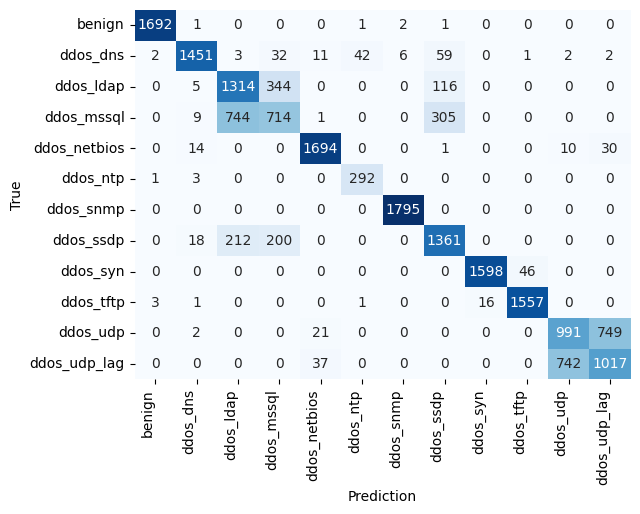

In [170]:
confusion = confusion_matrix(y_test, grid_search_knn.predict(X_test))

# Plot the confusion matrix
plt.figure()
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right')
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right')
plt.xlabel('Prediction')
plt.ylabel('True')
#plt.title('Confusion matrix')
plt.show()

#### Logistic Regression

In [150]:
print_classification_report("Logistic Regression", grid_search_lr)

Logistic Regression fit time: 46.91s - Predict time: 0.01s

Training set
              precision    recall  f1-score   support

      benign       0.95      0.96      0.95      3961
    ddos_dns       0.97      0.87      0.92      3758
   ddos_ldap       0.50      0.64      0.56      4149
  ddos_mssql       0.22      0.03      0.05      4138
ddos_netbios       0.91      0.95      0.93      4081
    ddos_ntp       0.70      0.68      0.69       690
   ddos_snmp       0.99      1.00      1.00      4189
   ddos_ssdp       0.55      0.92      0.69      4179
    ddos_syn       0.96      0.98      0.97      3836
   ddos_tftp       0.97      0.96      0.96      3683
    ddos_udp       0.52      0.54      0.53      4113
ddos_udp_lag       0.53      0.48      0.50      4190

    accuracy                           0.75     44967
   macro avg       0.73      0.75      0.73     44967
weighted avg       0.73      0.75      0.73     44967

Test set
              precision    recall  f1-score   suppo

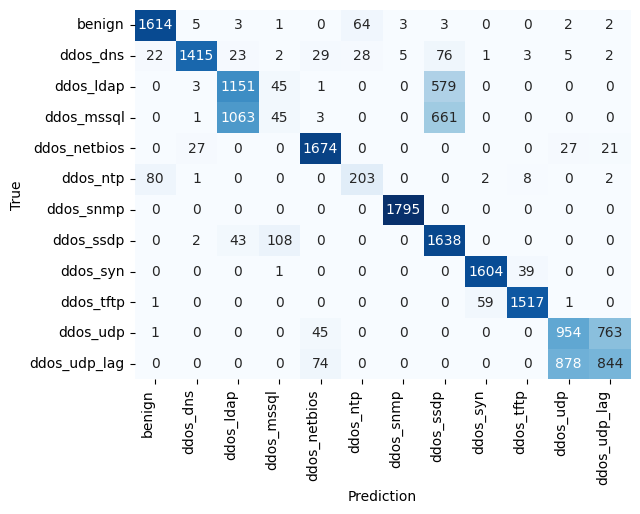

In [169]:
confusion = confusion_matrix(y_test, grid_search_lr.predict(X_test))

# Plot the confusion matrix
plt.figure()
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right')
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right')
plt.xlabel('Prediction')
plt.ylabel('True')
#plt.title('Confusion matrix')
plt.show()

#### Random Forest

In [151]:
print_classification_report("Random Forest", grid_search_rf)

Random Forest fit time: 1.38s - Predict time: 0.22s

Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      0.98      0.99      3758
   ddos_ldap       0.84      0.94      0.89      4149
  ddos_mssql       0.90      0.61      0.73      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       0.99      1.00      0.99       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       0.81      0.98      0.88      4179
    ddos_syn       0.98      0.99      0.99      3836
   ddos_tftp       0.99      0.98      0.98      3683
    ddos_udp       0.74      0.72      0.73      4113
ddos_udp_lag       0.73      0.76      0.74      4190

    accuracy                           0.90     44967
   macro avg       0.91      0.91      0.91     44967
weighted avg       0.91      0.90      0.90     44967

Test set
              precision    recall  f1-score   support

   

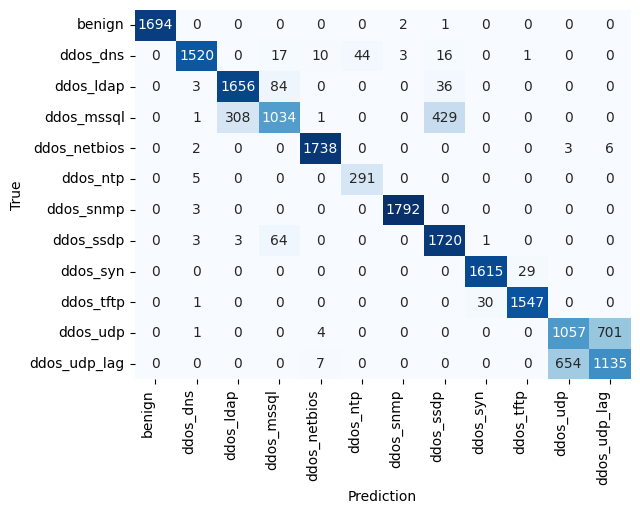

In [168]:
confusion = confusion_matrix(y_test, grid_search_rf.predict(X_test))

# Plot the confusion matrix
plt.figure()
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right')
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right')
plt.xlabel('Prediction')
plt.ylabel('True')
#plt.title('Confusion matrix')
plt.show()

#### Gaussian Naive Bayes

In [152]:
print_classification_report("Gaussian Naive Bayes", grid_search_nb)

Gaussian Naive Bayes fit time: 0.01s - Predict time: 0.05s

Training set
              precision    recall  f1-score   support

      benign       0.99      0.74      0.85      3961
    ddos_dns       0.98      0.80      0.88      3758
   ddos_ldap       1.00      0.00      0.00      4149
  ddos_mssql       0.44      0.63      0.52      4138
ddos_netbios       0.91      0.71      0.79      4081
    ddos_ntp       0.39      0.93      0.55       690
   ddos_snmp       0.96      1.00      0.98      4189
   ddos_ssdp       0.54      0.88      0.67      4179
    ddos_syn       0.97      0.42      0.58      3836
   ddos_tftp       0.62      0.98      0.76      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.44      0.99      0.61      4190

    accuracy                           0.65     44967
   macro avg       0.69      0.67      0.60     44967
weighted avg       0.70      0.65      0.60     44967

Test set
              precision    recall  f1-score   suppo

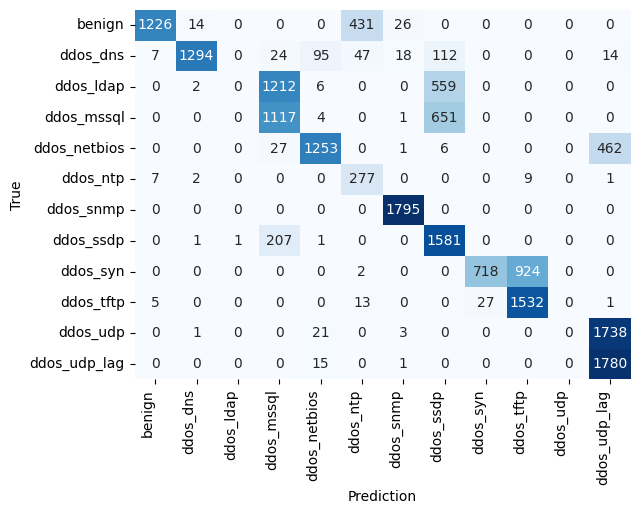

In [166]:
confusion = confusion_matrix(y_test, grid_search_nb.predict(X_test))

# Plot the confusion matrix
plt.figure()
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right')
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right')
plt.xlabel('Prediction')
plt.ylabel('True')
#plt.title('Confusion matrix')
plt.show()

#### SVM

In [153]:
print_classification_report("SVM", grid_search_svc)

SVM fit time: 393.81s - Predict time: 0.01s

Training set
              precision    recall  f1-score   support

      benign       0.93      0.96      0.94      3961
    ddos_dns       1.00      0.80      0.89      3758
   ddos_ldap       0.49      0.66      0.56      4149
  ddos_mssql       0.13      0.02      0.03      4138
ddos_netbios       0.51      0.98      0.67      4081
    ddos_ntp       0.67      0.61      0.64       690
   ddos_snmp       0.98      1.00      0.99      4189
   ddos_ssdp       0.54      0.87      0.66      4179
    ddos_syn       0.96      0.98      0.97      3836
   ddos_tftp       0.97      0.95      0.96      3683
    ddos_udp       0.51      0.36      0.42      4113
ddos_udp_lag       0.50      0.23      0.32      4190

    accuracy                           0.70     44967
   macro avg       0.68      0.70      0.67     44967
weighted avg       0.68      0.70      0.67     44967

Test set
              precision    recall  f1-score   support

      benig

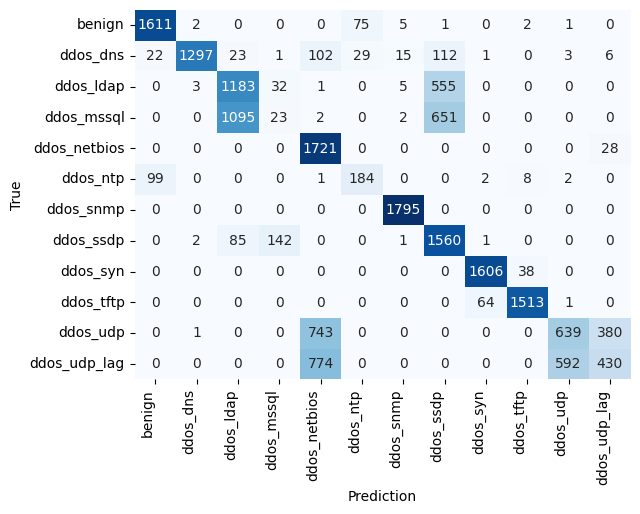

In [167]:
confusion = confusion_matrix(y_test, grid_search_svc.predict(X_test))

# Plot the confusion matrix
plt.figure()
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right')
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right')
plt.xlabel('Prediction')
plt.ylabel('True')
#plt.title('Confusion matrix')
plt.show()

As seen above, the random forest is the one that allows us to reach the best accuracy on the validation set (87%), followed by k-NN (81%) and logistic regression (75%).

### Learning Curve
Now that we have found the best features and configurations we need to understand what is the optimal number of training samples we should use. To do this we can use the learning curve.
1. First, we select the best model with the best configuration. Then, we define the range of portion of training sample. The goal is to find the proper portion that can generate an accuracy on validation greater than a certain threshold (here, 87%)
2. For each of the percentage in the range, we perform a random stratified sampling for k=5 times, and train our model with different portions of training set.

In [154]:
info_accuracy_train_lc = []
info_accuracy_val_lc = []

random.seed(22)

for train_size in np.arange(0.1, 1.0, 0.1):
    start = time.time()
    # select 5 random states
    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuracies_train_tmp = []
    accuracies_val_tmp = []

    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:

        # further split into training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            stratify = y_train_val,
            train_size = train_size,
            random_state = random_state
        )

        best_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=11)
        best_model.fit(X_train, y_train.ravel())
        accuracies_train_tmp.append(accuracy_score(y_train, best_model.predict(X_train)))
        accuracies_val_tmp.append(accuracy_score(y_val, best_model.predict(X_val)))

    # calculate the statistics to generate overall performance
    accuracies_tmp = np.array(accuracies_train_tmp)
    mean_acc_train = accuracies_tmp.mean()
    min_acc_train = accuracies_tmp.min()
    max_acc_train = accuracies_tmp.max()
    info_accuracy_train_lc.append((mean_acc_train, min_acc_train, max_acc_train))

    accuracies_tmp = np.array(accuracies_val_tmp)
    mean_acc_val = accuracies_tmp.mean()
    min_acc_val = accuracies_tmp.min()
    max_acc_val = accuracies_tmp.max()
    info_accuracy_val_lc.append((mean_acc_val, min_acc_val, max_acc_val))

    print(f'Train portion = {train_size:.2f} - Time = {time.time() - start:.2f} s | Accuracy train/val = {mean_acc_train:.4f}/{mean_acc_val:.4f}')

Train portion = 0.10 - Time = 1.56 s | Accuracy train/val = 0.9575/0.8469
Train portion = 0.20 - Time = 2.33 s | Accuracy train/val = 0.9407/0.8570
Train portion = 0.30 - Time = 2.76 s | Accuracy train/val = 0.9300/0.8649
Train portion = 0.40 - Time = 3.31 s | Accuracy train/val = 0.9221/0.8660
Train portion = 0.50 - Time = 3.98 s | Accuracy train/val = 0.9176/0.8684
Train portion = 0.60 - Time = 4.81 s | Accuracy train/val = 0.9144/0.8693
Train portion = 0.70 - Time = 5.37 s | Accuracy train/val = 0.9119/0.8708
Train portion = 0.80 - Time = 6.21 s | Accuracy train/val = 0.9091/0.8736
Train portion = 0.90 - Time = 6.68 s | Accuracy train/val = 0.9067/0.8729


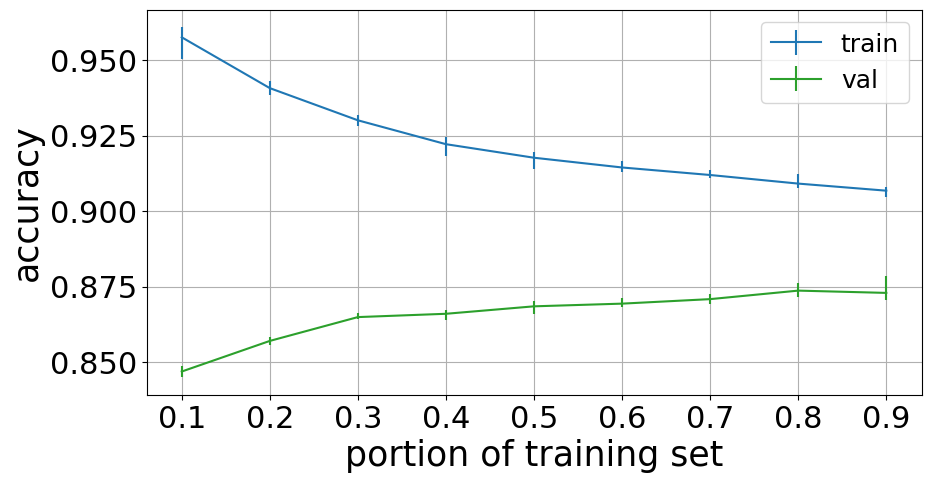

In [155]:
plt.figure(figsize=(10,5))
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_train_lc], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_train_lc],
        [info[2]-info[0] for info in info_accuracy_train_lc]
    ],
    color='tab:blue', label='train'
)
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_val_lc], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_val_lc],
        [info[2]-info[0] for info in info_accuracy_val_lc]
    ],
    color='tab:green', label='val'
)
plt.grid()
plt.xlabel('portion of training set', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.tick_params(labelsize=22)
plt.xticks(np.arange(0.1, 1, 0.1))
#plt.title('Learning curve for Random Forest')
plt.legend(fontsize=18)
plt.show()

A portion of 70% is quite effective, as it achieves an accuracy higher than 87%.

### Testing our best model on test set
Based on the previous analysis, we retrain our final model with all of the aforementioned best selections on all data except test set. In conclusion, we output the final performance in terms of classification report and confusion matrix on the test set.

In [156]:
final_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=11)
final_model.fit(X_train_val, y_train_val)
y_pred = final_model.predict(X_test)

In [157]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1697
           1       0.99      0.94      0.97      1611
           2       0.84      0.93      0.88      1779
           3       0.86      0.58      0.70      1773
           4       0.99      0.99      0.99      1749
           5       0.87      0.98      0.92       296
           6       1.00      1.00      1.00      1795
           7       0.78      0.96      0.86      1791
           8       0.98      0.98      0.98      1644
           9       0.98      0.98      0.98      1578
          10       0.62      0.60      0.61      1763
          11       0.62      0.63      0.62      1796

    accuracy                           0.87     19272
   macro avg       0.88      0.88      0.88     19272
weighted avg       0.87      0.87      0.87     19272



#### Performance considerations
The final model performs quite well on the test set, achieving an accuracy of 87%. The classification report shows high precision, recall, and F1-score values for most classes, indicating that the model tends to correctly identify both benign and attack types. This suggests the model has successfully generalized from the training data to the test set. The results are consistent and reliable, thus confirming the robustness of our final model. The main misclassifications are among ddos_udp and doos_udp_lag.


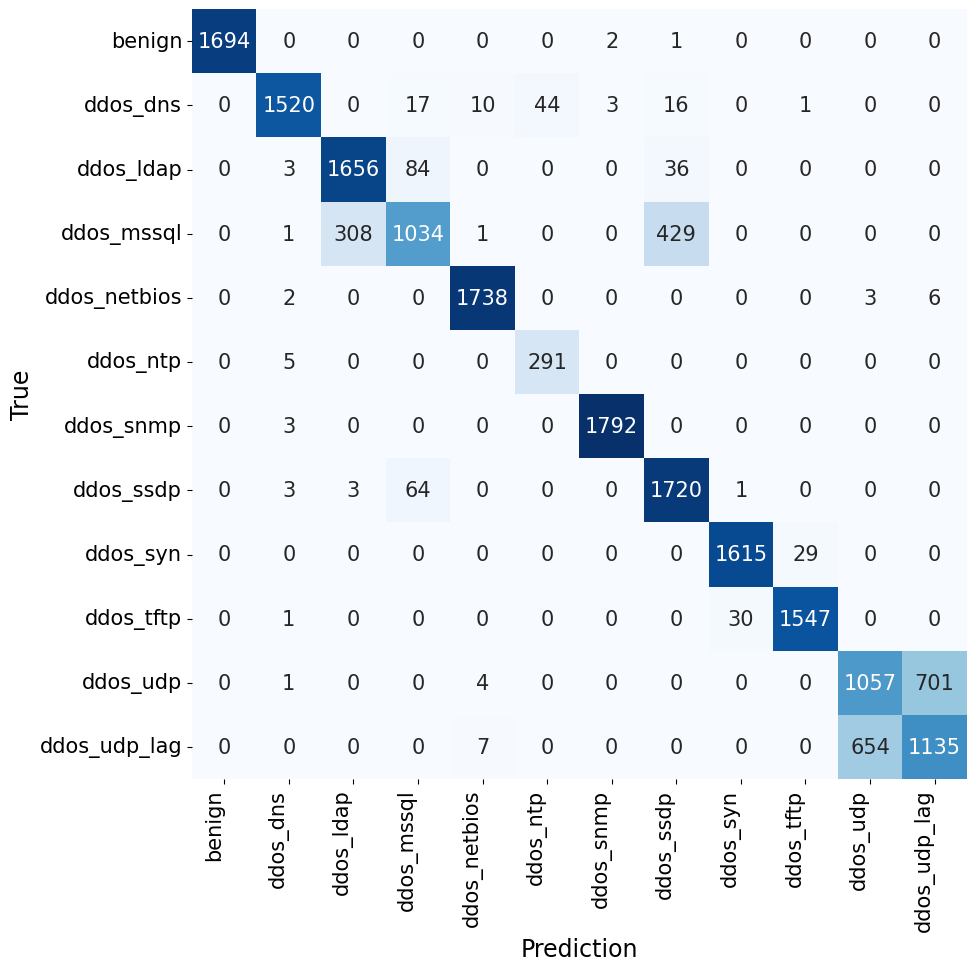

In [158]:
# Confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)


# Plot the confusion matrix
plt.figure(figsize=(10,10))
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, annot_kws={'size': 15}, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=0, ha='right', fontsize=15)
fig.xaxis.set_ticklabels(sorted(np.unique(df['label'])), rotation=90, ha='right', fontsize=15)
plt.xlabel('Prediction', fontsize=17)
plt.ylabel('True', fontsize=17)
#plt.title('Confusion matrix')
plt.show()



### Considerations:
Overall, most classes have a high value of correct predictions along the diagonal, indicating a good level of accuracy.
1. Class 5 ('_ddos_ntp_') shows only 291 correct predictions, because few samples belonging to this class are available in the dataset.
2. There are slight misclassifications between:
    - ddos_ldap and ddos_mssql: in particular, ddos_mssql are predicted as ddos_ldap
    - ddos_udp and ddos_udp_lag
    - ddos_mssql and ddos_ssdp: in particular, ddos_mssql are predicted as ddos_ssdp

#### FP, FN, Recall, and Precision in a DDoS Detection Context
FN: These represent normal traffic erroneously classified as an attack. A high FN rate can lead to false alarms, overwhelming security systems and reducing operational efficiency.

FP: These represent undetected attacks, which are critical as malicious traffic can harm services without being intercepted, thus leading to miss subtle attacks.

Recall: Measures the system’s ability to detect attacks (avoiding FN). Achieving a high precision is important to minimize false alarms and maintain realiability in the system.

Precision: Reflects how accurate the system is in detecting attacks (avoiding FP). Having a high recall is crucial in scenarios where missed attacks represent significant threats. 

Real-World Scenarios: Low precision could lead to missing critical attacks, while low recall may generate excessive false alarms, possibly confusing security managers and reducing the effectiveness of the defense system.


### Feature Importance

In [159]:
start_time = time.time()
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.007 seconds


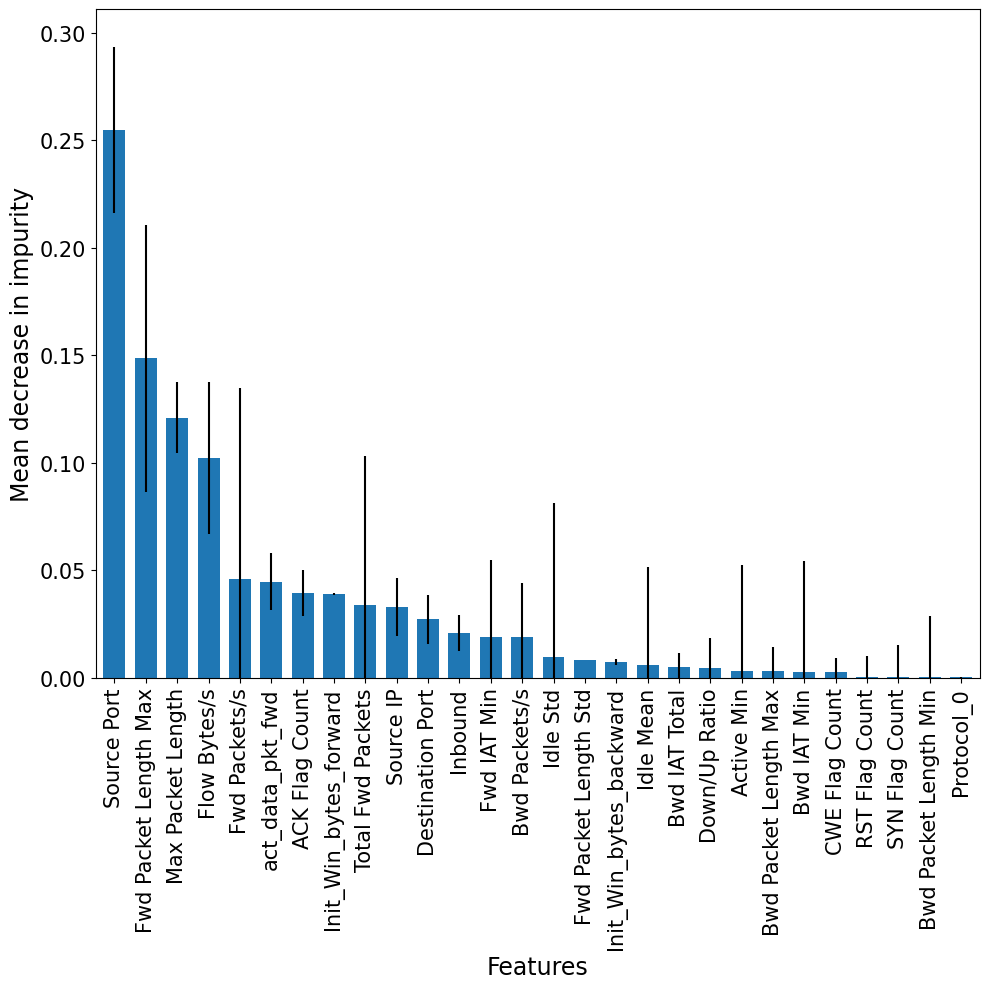

In [171]:
forest_importances = pd.Series(importances, index=X_test_df.columns)
forest_importances = forest_importances.sort_values(ascending=False)
plt.figure(figsize=(10,10))
forest_importances.plot.bar(yerr=std, width=0.7)
plt.ylabel("Mean decrease in impurity", fontsize=17)
plt.xlabel("Features", fontsize=17)
plt.ylim(bottom=0)
plt.tick_params(labelsize=15)
plt.tight_layout()

The most important features for our model are the source port, the packet length and the rates: the misclassified samples may have similar values of these features.